In [2]:
import pandas as pd


df_hdi = pd.read_csv('data/hdi_table.csv', index_col = [0])
df_hdi = df_hdi.reset_index(drop=True)

df_hdi_population = pd.read_csv('data/hdi_table_population.csv', index_col = [0])
df_hdi_population = df_hdi_population.reset_index(drop=True)

df_hdi_population = df_hdi_population.rename(columns={'MixedLM With FE':'MixedLM With FE & Pop'})

df_hdi = pd.merge(df_hdi, df_hdi_population, on = ['measure', 'OLS Without FE', 'Variable'])

In [3]:
df_gdp = pd.read_csv('data/regression_table_gdp.csv')
df_gdp = df_gdp.rename(columns={'Unnamed: 0':'measure'})

df_gdp_pop = pd.read_csv('data/regression_table_gdp_pop.csv')
df_gdp_pop = df_gdp_pop.rename(columns={'Unnamed: 0':'measure'})
df_gdp_pop = df_gdp_pop.rename(columns={'MixedLM With FE':'MixedLM With FE & Pop'})
df_gdp_pop = df_gdp_pop.drop('Variable', axis=1)

df_gdp_final = pd.merge(df_gdp, df_gdp_pop, on = ['measure', 'OLS Without FE'])


df_hdi = pd.concat([df_hdi, df_gdp_final])
df_hdi.to_csv('data/final_hdi_pop_non_pop.csv')

In [4]:
data = df_hdi[df_hdi['measure']!='R-squared']

import pandas as pd
import numpy as np
import re

def process_regression_dataframe(df):
    """
    Process regression data from a dataframe into a format suitable for plotting.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Dataframe containing regression results with columns:
        - 'measure': type of measurement (e.g., 'Coef', 'Coef_CI', 'Coef_p-value')
        - 'Variable': the variable name
        - Model columns: 'OLS Without FE', 'MixedLM With FE', etc.
        
    Returns:
    --------
    pandas.DataFrame
        Processed data ready for plotting with columns:
        Variable, Model, Coefficient, Lower_CI, Upper_CI, p_value, Significant
    """
    # Function to extract confidence interval values
    def extract_ci(ci_string):
        """Extract lower and upper confidence interval values from a string like '(0.12, 0.45)'"""
        if pd.isna(ci_string):
            return np.nan, np.nan
        
        # Convert bytes to string if necessary
        if isinstance(ci_string, bytes):
            ci_string = ci_string.decode('utf-8')
        
        # Make sure ci_string is actually a string
        ci_string = str(ci_string)
            
        ci_match = re.match(r'\(([-\d.]+),\s*([-\d.]+)\)', ci_string)
        if ci_match:
            return float(ci_match.group(1)), float(ci_match.group(2))
        return np.nan, np.nan
    
    # Prepare the data for plotting
    plot_data = []
    
    # Get unique variables and models
    variables = df['Variable'].unique()
    models = [col for col in df.columns if col not in ['', 'measure', 'Variable']]
    
    for variable in variables:
        variable_data = df[df['Variable'] == variable]
        
        for model in models:
            # Skip if model column doesn't exist
            if model not in df.columns:
                continue
                
            # Get coefficient
            coef_rows = variable_data[variable_data['measure'] == 'Coef']
            if coef_rows.empty or pd.isna(coef_rows[model].iloc[0]):
                continue
            
            try:
                coef_value = float(coef_rows[model].iloc[0])
            except (ValueError, TypeError):
                # Skip if coefficient can't be converted to float
                continue
            
            # Get confidence interval
            ci_rows = variable_data[variable_data['measure'] == 'Coef_CI']
            if ci_rows.empty or pd.isna(ci_rows[model].iloc[0]):
                continue
                
            ci_string = ci_rows[model].iloc[0]
            lower_ci, upper_ci = extract_ci(ci_string)
            
            # Get p-value
            p_value = np.nan
            p_value_rows = variable_data[variable_data['measure'] == 'Coef_p-value']
            if not p_value_rows.empty and not pd.isna(p_value_rows[model].iloc[0]):
                try:
                    p_value = float(p_value_rows[model].iloc[0])
                except (ValueError, TypeError):
                    # If p-value can't be converted to float, keep as NaN
                    pass
            
            # Determine significance (using 0.05 as default threshold)
            significant = False if np.isnan(p_value) else p_value < 0.05
            
            # Add row to results
            plot_data.append({
                'Variable': variable,
                'Model': model,
                'Coefficient': coef_value,
                'Lower_CI': lower_ci,
                'Upper_CI': upper_ci,
                'p_value': p_value,
                'Significant': significant
            })
    
    # Convert to DataFrame
    plot_df = pd.DataFrame(plot_data)
    
    # Sort by variable name and model
    if not plot_df.empty:
        plot_df = plot_df.sort_values(['Variable', 'Model'])
    
    return plot_df

data_process = process_regression_dataframe(data)
data_process


,Variable,Model,Coefficient,Lower_CI,Upper_CI,p_value,Significant
1,Gender_equality_num,MixedLM With FE,0.21,-0.06,0.48,0.131,False
2,Gender_equality_num,MixedLM With FE & Pop,0.17,-0.13,0.47,0.258,False
0,Gender_equality_num,OLS Without FE,0.28,0.12,0.45,0.001,True
25,gdp,MixedLM With FE,0.47,0.41,0.53,0.000,True
26,gdp,MixedLM With FE & Pop,0.24,0.15,0.33,0.000,True
24,gdp,OLS Without FE,0.50,0.42,0.57,0.000,True
4,height,MixedLM With FE,0.04,-0.21,0.30,0.749,False
5,height,MixedLM With FE & Pop,0.11,-0.17,0.39,0.441,False
3,height,OLS Without FE,0.26,0.08,0.43,0.004,True
7,homicide_rate,MixedLM With FE,-0.06,-0.19,0.07,0.391,False


Nature-style table saved as nature_regression_table.png


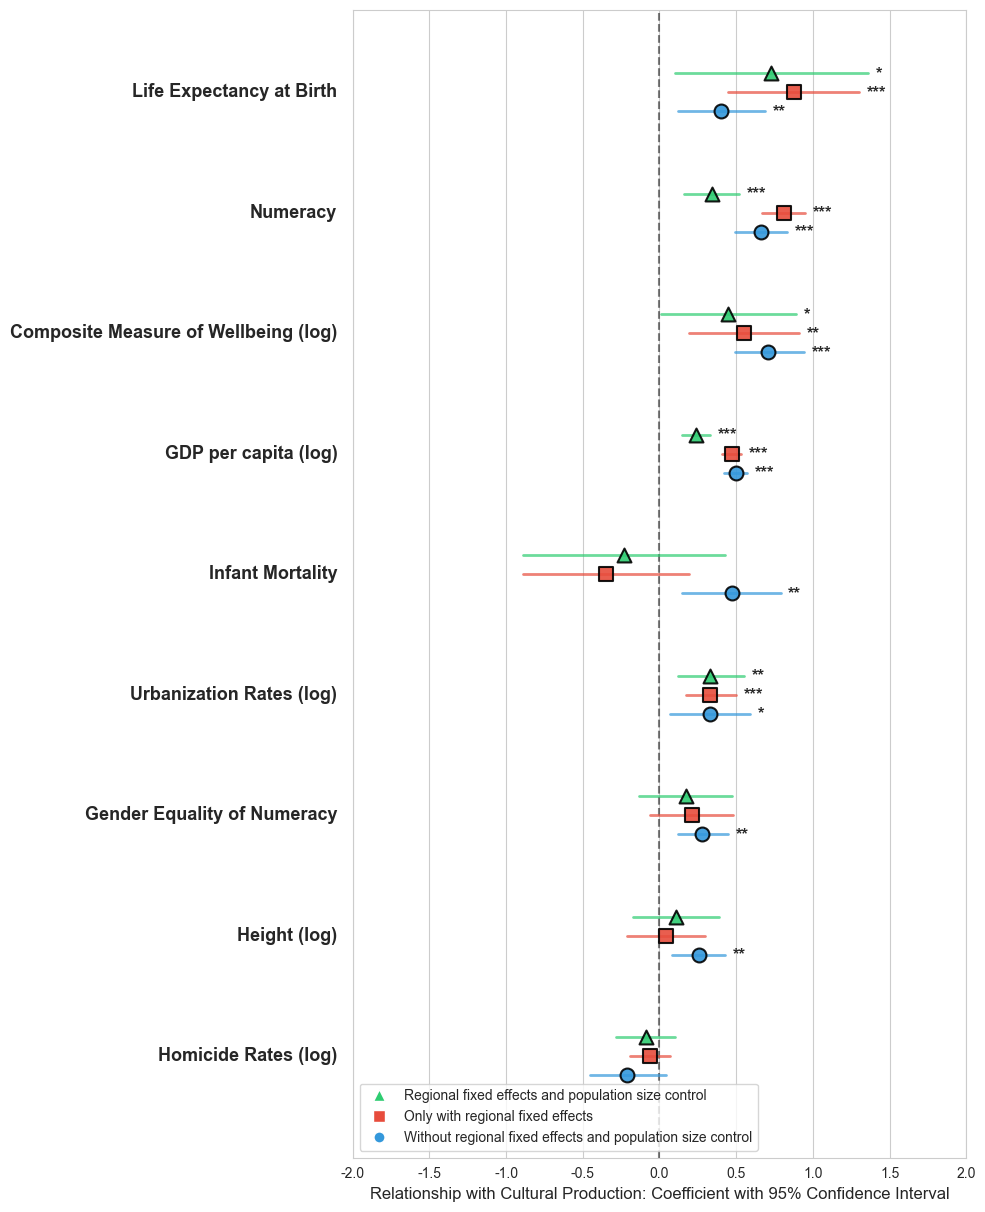

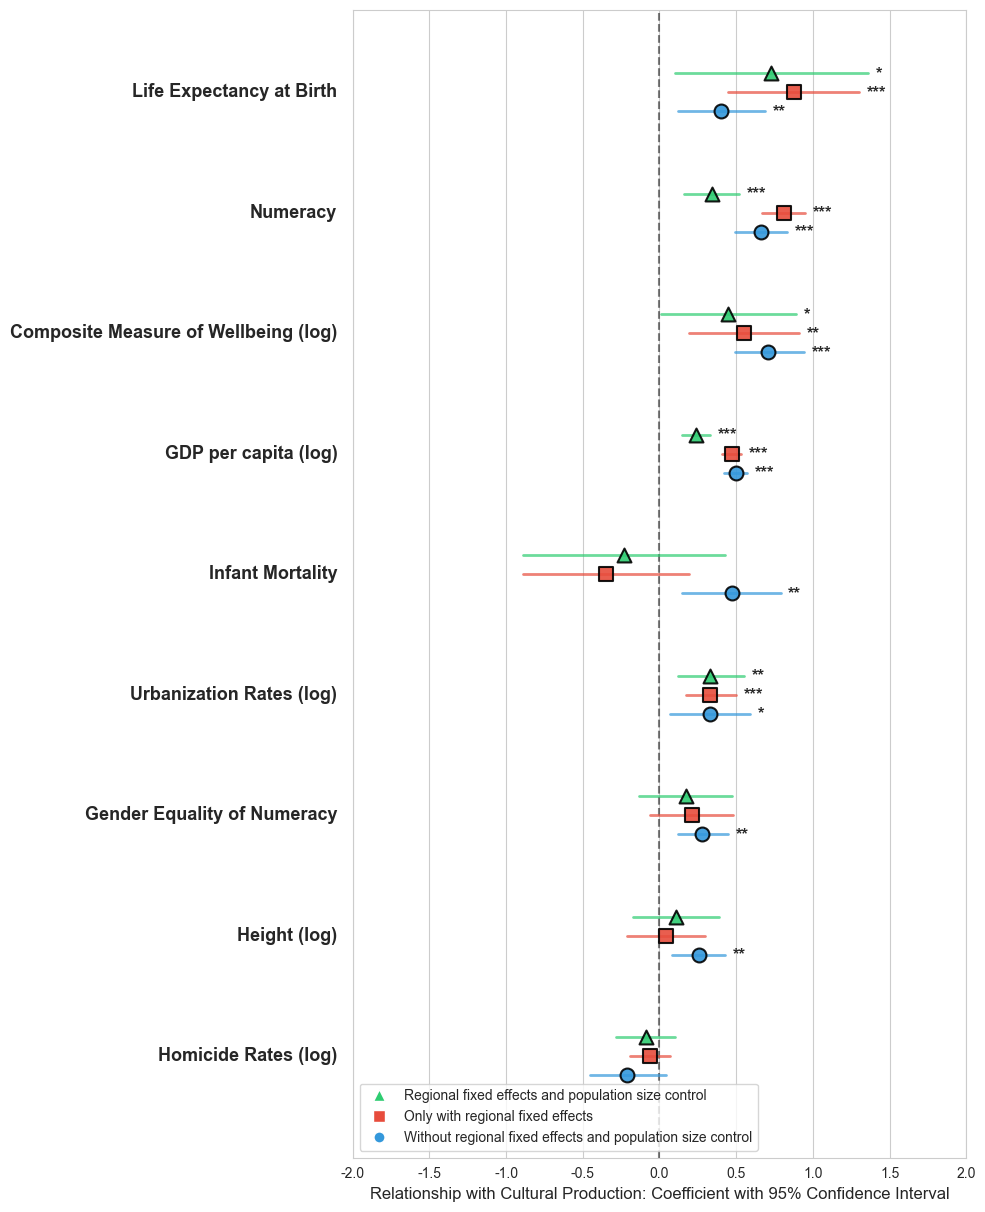

In [5]:
def plot_forest(plot_df, save_path=None, figsize=(16, 14), sort_by_effect=True):
    """
    Create a forest plot from processed regression data, without displaying numerical values.
    
    Parameters:
    -----------
    plot_df : pandas.DataFrame
        Processed dataframe with columns:
        Variable, Model, Coefficient, Lower_CI, Upper_CI, p_value, Significant
    
    save_path : str, optional
        Path to save the plot (e.g., 'forest_plot.png'). If None, plot is not saved.
    
    figsize : tuple, optional
        Figure size (width, height) in inches
    
    sort_by_effect : bool, optional
        If True, sort variables by effect size (largest absolute coefficient first)
        If False, sort alphabetically
        
    Returns:
    --------
    matplotlib.figure.Figure
        The created figure object
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib.lines import Line2D
    import numpy as np
    
    # Set the style
    sns.set_style('whitegrid')
    plt.figure(figsize=figsize)
    
    # Define variable name mapping
    variable_names = {
        'numeracy': 'Numeracy',
        'height': 'Height (log)',
        'Gender_equality_num': 'Gender Equality of Numeracy',
        'wellbeing': 'Composite Measure of Wellbeing (log)',
        'homicide_rate': 'Homicide Rates (log)',
        'infant_mortality': 'Infant Mortality',
        'life_expectancy': 'Life Expectancy at Birth',
        'gdp': 'GDP per capita (log)',
        'urbanization': 'Urbanization Rates (log)'
    }
    
    # Model name mapping
    model_names = {
        'OLS Without FE': 'Without regional fixed effects and population size control',
        'MixedLM With FE': 'Only with regional fixed effects',
        'MixedLM With FE & Pop': 'Regional fixed effects and population size control'
    }
    
    # Sort variables if requested
    if sort_by_effect:
        # Calculate average absolute coefficient for each variable
        var_effects = plot_df.groupby('Variable')['Coefficient'].apply(lambda x: np.mean(np.abs(x)))
        var_order = var_effects.sort_values(ascending=False).index.tolist()
    else:
        # Sort alphabetically
        var_order = sorted(plot_df['Variable'].unique())
    
    # Define model colors, markers, and positions
    model_colors = {
        'OLS Without FE': '#3498db',        # Blue
        'MixedLM With FE': '#e74c3c',       # Red
        'MixedLM With FE & Pop': '#2ecc71'  # Green
    }
    
    model_markers = {
        'OLS Without FE': 'o',         # Circle
        'MixedLM With FE': 's',        # Square
        'MixedLM With FE & Pop': '^'   # Triangle
    }
    
    # Updated model order: Population, Mixed with FE, Non-FE
    model_order = ['MixedLM With FE & Pop', 'MixedLM With FE', 'OLS Without FE']
    
    # Spacing parameters
    var_positions = {}
    y_pos = 0
    var_spacing = 1.0    # Space between variables
    model_spacing = 0.3  # Space between models within a variable
    
    # Define consistent marker size and style for all points, regardless of significance
    marker_size = 10
    marker_edge_width = 1.5
    marker_alpha = 0.9
    
    # Plot each variable
    for variable in var_order:
        var_df = plot_df[plot_df['Variable'] == variable]
        
        # Track the variable starting position
        var_positions[variable] = y_pos
        
        # Sort models in consistent order
        var_df = var_df.set_index('Model').loc[
            [m for m in model_order if m in var_df['Model'].values]
        ].reset_index()
        
        # Plot each model for this variable
        for i, (_, row) in enumerate(var_df.iterrows()):
            model = row['Model']
            coef = row['Coefficient']
            lower = row['Lower_CI']
            upper = row['Upper_CI']
            p_value = row['p_value']
            significant = row['Significant']
            
            # Current y position for this model
            current_y = y_pos - i * model_spacing
            
            # Plot confidence interval line
            plt.plot([lower, upper], [current_y, current_y], 
                     color=model_colors[model], alpha=0.7, linewidth=2)
            
            # Plot coefficient point with consistent marker size and style
            plt.scatter(coef, current_y, color=model_colors[model], 
                       marker=model_markers[model],
                       s=marker_size**2, zorder=3, alpha=marker_alpha,
                       edgecolor='black', linewidth=marker_edge_width)
            
            # Add significance marker
            sig_marker = ''
            if not np.isnan(p_value):
                if p_value < 0.001:
                    sig_marker = '***'
                elif p_value < 0.01:
                    sig_marker = '**'
                elif p_value < 0.05:
                    sig_marker = '*'
                
            plt.text(upper + 0.05, current_y, sig_marker, 
                     verticalalignment='center', fontsize=12, fontweight='bold')
            
            # No coefficient values or p-values displayed
        
        # Move to next variable
        y_pos -= (len(var_df) * model_spacing) + var_spacing
    
    # Add variable labels at the midpoint of each variable's positions with mapped names
    for variable, pos in var_positions.items():
        var_df = plot_df[plot_df['Variable'] == variable]
        var_height = (len(var_df) - 1) * model_spacing
        midpoint = pos - var_height / 2
        
        # Use the mapped variable name or the original if not found
        display_name = variable_names.get(variable, variable)
        
        # Position variable names on the left side, away from the axis
        plt.text(-2.1, midpoint, display_name, fontsize=13, 
                 horizontalalignment='right', verticalalignment='center',
                 fontweight='bold')
    
    # Add vertical line at zero
    plt.axvline(x=0, color='black', linestyle='--', alpha=0.5, zorder=1)
    
    # Create legend for models with updated names and in the new order
    model_legend = [
        Line2D([0], [0], marker=model_markers.get(model, 'o'), color='w', 
               markerfacecolor=model_colors.get(model, 'gray'), 
               markersize=8, label=model_names.get(model, model))
        for model in model_order if model in plot_df['Model'].unique()
    ]
    
    # No significance legend in the main legend area
    legend_elements = model_legend
    plt.legend(handles=legend_elements, loc='lower left', fontsize=10)
    
    # Set plot limits and labels
    data_range = plot_df[['Lower_CI', 'Upper_CI']].values.flatten()
    x_min = -2.0  # Hard cap at -2.0 as requested
    x_max = max(data_range) + 0.6
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_pos, 1)
    
    # Add x-axis tick labels
    x_ticks = np.arange(x_min, round(x_max * 2) / 2 + 0.5, 0.5)
    plt.xticks(x_ticks, [f"{x:.1f}" for x in x_ticks])
    
    # Updated x-axis label to include relationship with Cultural Production
    plt.xlabel('Relationship with Cultural Production: Coefficient with 95% Confidence Interval', fontsize=12)
    
    # Title is commented out as in the original script
    # plt.title('Forest Plot of Regression Coefficients by Variable and Model', fontsize=14)
    
    # Remove y-axis ticks and labels
    plt.yticks([])
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    
    # Save the plot if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return plt.gcf()

plot_forest(data_process, figsize = (10, 13))